In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab
import torch
import sys
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from TMCRBM import TMCRBM
from scipy.integrate import simps
from scipy import stats
import h5py

device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

In [2]:
#data = np.genfromtxt('../dataset/data_1d2c_bal_seed14.dat')
#data = torch.tensor((data+1)/2, device = device, dtype = dtype)
#data = torch.tensor(np.genfromtxt('../dataset/data_1d3c.dat'), device = device, dtype = dtype)
data = torch.tensor(np.genfromtxt('../dataset/C1d5c/data_5.dat'), device = device, dtype = dtype)

data = (data+1)/2

In [3]:
data.shape

torch.Size([2000, 1000])

In [4]:
#f = h5py.File("../model/AllParametersRBM_NGibbs_20_Nh40_Ns1000_Nmb200_Nepoch1000_lr_0.01.h5", 'r')#TMCRBM
#f = h5py.File("../model/AllParametersRBM_NGibbs_20_Nh40_Ns1000_Nmb200_Nepoch100_lr_0.01_normal.h5", 'r')#normal RBM
f = h5py.File("../model/AllParametersTMCRBM_NGibbs_50_Nh40_Nv1000_Nmb200_Nepoch1000_lr_0.1_N20000_Npoint1000_Nchain15_phase3.h5", 'r')
#f = h5py.File("../model/AllParametersTMCRBM_NGibbs_50_Nh40_Nv1000_Nmb200_Nepoch100_lr_0.01_N20000_Npoint1000_Nchain15_phase3.h5", 'r')
#f = h5py.File("../model/AllParametersTMCRBM_NGibbs_25_Nh20_Nv1000_Nmb200_Nepoch100_lr_0.1_N20000_Npoint1000_Nchain15_phase2.h5", 'r')
#f = h5py.File("../model/AllParametersTMCRBM_NGibbs_10_Nh20_Nv1000_Nmb200_Nepoch100_lr_0.01_N20000_Npoint1000_Nchain15.h5", 'r')
#f = h5py.File("../model/AllParametersTMCRBM_NGibbs_25_Nh20_Nv1000_Nmb200_Nepoch100_lr_0.01_N20000_Npoint1000_Nchain15_phase2.h5", 'r')
#f = h5py.File("../model/AllParametersTMCRBM_NGibbs_25_Nh20_Nv1000_Nmb200_Nepoch100_lr_0.001_N20000_Npoint1000_Nchain15_phase2.h5", 'r')
#f = h5py.File("../model/AllParametersTMCRBM_NGibbs_50_Nh20_Nv1000_Nmb200_Nepoch10_lr_0.001_N20000_Npoint1000_Nchain15_phase2.h5", 'r')
#f = h5py.File("../model/AllParametersRBM_NGibbs_20_Nh100_Ns1000_Nmb200_Nepoch100_lr_0.001.h5", 'r')

#f = h5py.File("../model/AllParametersTMCRBM_NGibbs_10_Nh20_Nv1000_Nmb200_Nepoch100_lr_0.001_N20000_Npoint1000_Nchain15.h5", 'r')

In [5]:
# Get all registered times
alltimes = []
for t in f['alltime'][:]:
    if 'W'+str(t) in f:
        alltimes.append(t)
print(alltimes)

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 18, 22, 24, 25, 26, 28, 32, 38, 41, 42, 43, 45, 48, 49, 55, 65, 69, 70, 71, 73, 77, 82, 83, 93, 110, 118, 119, 120, 122, 126, 132, 138, 142, 159, 187, 201, 202, 203, 205, 209, 215, 225, 236, 242, 270, 319, 342, 343, 344, 346, 350, 356, 366, 383, 402, 411, 460, 543, 582, 583, 584, 586, 590, 596, 606, 623, 651, 684, 700, 783, 924, 990, 991, 992, 994, 998, 1004, 1014, 1031, 1059, 1108, 1164, 1191, 1332, 1572, 1683, 1684, 1685, 1687, 1691, 1697, 1707, 1724, 1752, 1801, 1884, 1980, 2025, 2265, 2673, 2862, 2863, 2864, 2866, 2870, 2876, 2886, 2903, 2931, 2980, 3063, 3204, 3366, 3444, 3852]


In [6]:
t = alltimes[-1]
lr = 0.01
NGibbs = 100
annSteps = 0
mb_s = 600
num_pcd = 100
Nh = torch.tensor(f['W0']).shape[0]
Nv = data.shape[1]
ep_max = 10
w_hat = torch.linspace(0,1,steps=100)
_, S_d, V = torch.svd(data)
V0 = V[:,0]
N = 20000
it_mean = 50

In [7]:
myRBM = TMCRBM(num_visible=Nv,
            num_hidden=Nh,
            device=device,
            lr=lr,
            gibbs_steps=NGibbs,
            UpdCentered=False,
            mb_s=mb_s,
            num_pcd=num_pcd,
            N = N,
            it_mean = it_mean,
           )

In [8]:
myRBM.W = torch.tensor(f['W'+str(t)], device = myRBM.device)
myRBM.hbias = torch.tensor(f['hbias'+str(t)], device = myRBM.device)
myRBM.vbias = torch.tensor(f['vbias'+str(t)], device = myRBM.device)
_, _, V_g = torch.svd(myRBM.W)
if torch.mean(V_g[:,0])<0:
    V_g = -V_g


In [9]:
#myRBM.fit(data.T, ep_max)

In [10]:
vinit = torch.bernoulli(torch.rand(
        (myRBM.Nv, 1000), device=myRBM.device, dtype=myRBM.dtype))
#vinit = torch.where(V_g[:,0]>0, 1, 0).repeat(2000).reshape(myRBM.Nv, 2000).float()
#vinit = data.T
si, _, _, _ = myRBM.Sampling(vinit, it_mcmc=1000)


In [11]:
nb_chain = 15  # Nb de chaines pour chaque w_hat
it_mcmc = 50  # Nb it_mcmc pour chaque chaine
it_mean = 20 # Nb it considérée pour la moyenne temporelle de chaque chaine
N = 20000  # Contrainte
nb_point = 1000  # Nb de points de discrétisation pour w_hat
start = torch.bernoulli(torch.rand(
    Nv, nb_chain*nb_point, device=device))
# SVD des poids
_, _, V0 = torch.svd(myRBM.W)
V0 = V0[:, 0]
# proj_data = torch.mv(X.T, V0)
# xmin = torch.min(proj_data)
if torch.mean(V0) < 0:
    V0 = -V0
#V0 = V[:,0]
proj_data = torch.mv(data, V_g[:,0])/Nv**0.5
xmin = torch.min(proj_data) - 0.2
xmax = torch.max(proj_data) + 0.2
w_hat_b = torch.linspace(
    xmin, xmax, steps=nb_point, device=device)
w_hat = torch.zeros(nb_chain*nb_point, device=device)
for i in range(nb_point):
    for j in range(nb_chain):
        w_hat[i*nb_chain+j] = w_hat_b[i]
tmpv, tmph, vtab = myRBM.TMCSample(
    start, w_hat, N, V0, it_mcmc=it_mcmc, it_mean=it_mean)
y = np.array(torch.mm(vtab.T, V0.unsqueeze(1)
                      ).cpu().squeeze())/Nv**0.5
newy = np.array([np.mean(y[i*nb_chain:i*nb_chain+nb_chain])
                 for i in range(nb_point)])
w_hat = w_hat.cpu().numpy()
w_hat_b_np = w_hat_b.cpu().numpy()

from scipy.interpolate import UnivariateSpline

res = np.zeros(len(w_hat_b)-1)
for i in range(4, len(w_hat_b)):
#    res[i-1] = simps(newy[:i]-w_hat_b_np[:i], w_hat_b_np[:i])
    TMPF = UnivariateSpline( w_hat_b_np[:i], newy[:i]-w_hat_b_np[:i])
    res[i-1] = TMPF.integral(w_hat_b_np[0], w_hat_b_np[-1])
    
#const = simps(np.exp(N*res-np.max(N*res)), w_hat_b_np[:-1])
TMPF2 = UnivariateSpline( w_hat_b_np[:-1], np.exp(N*res-np.max(N*res)))
const = TMPF2.integral(w_hat_b_np[0], w_hat_b_np[-1])
p_m = torch.tensor(np.exp(N*res-np.max(N*res)) /
                   const, device=myRBM.device)
s_i = torch.stack([torch.mean(
    tmpv[:, i*nb_chain:i*nb_chain+nb_chain], dim=1) for i in range(nb_point)], 1)
tau_a = torch.stack([torch.mean(
    tmph[:, i*nb_chain:i*nb_chain+nb_chain], dim=1) for i in range(nb_point)], 1)
s_i = torch.trapz(s_i[:, 1:]*p_m,w_hat_b[1:], dim=1)
tau_a = torch.trapz(tau_a[:, 1:]*p_m,w_hat_b[1:], dim=1)
prod = torch.zeros(
    (Nv, Nh, nb_point*nb_chain), device=device)
for i in range(tmpv.shape[1]):
    prod[:, :, i] = torch.outer(tmpv[:, i], tmph[:, i])
prod = torch.stack([torch.mean(
    prod[:, :, i*nb_chain:i*nb_chain+nb_chain], dim=2) for i in range(nb_point)], 2)
prod = torch.trapz(prod[:, :, 1:]*p_m, w_hat_b[1:], dim=2)

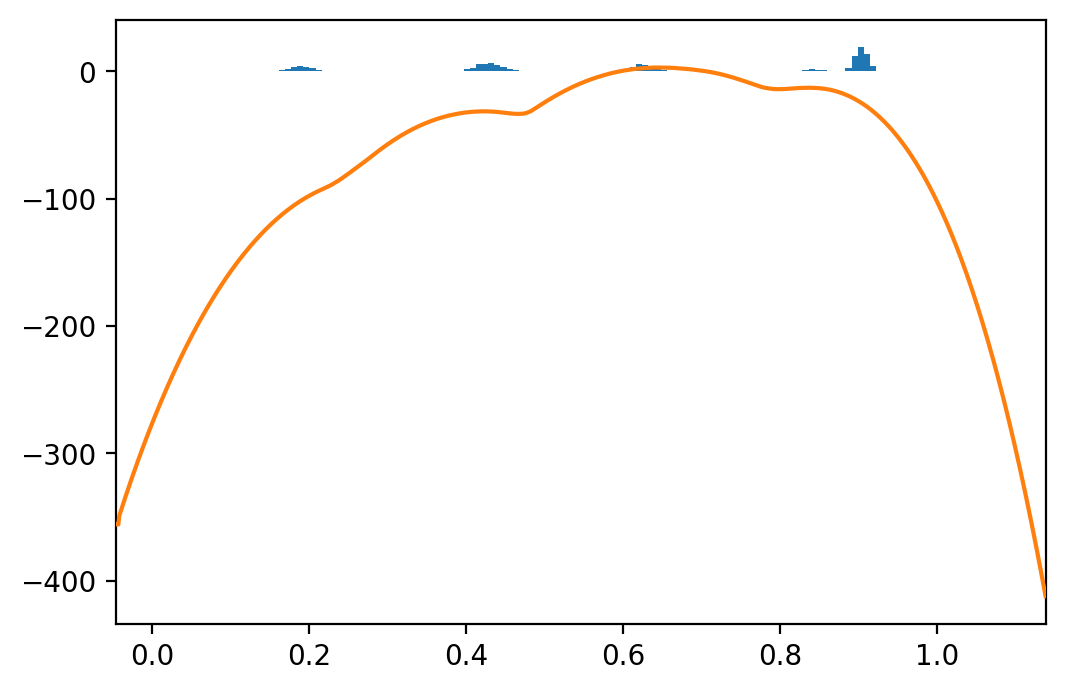

In [12]:
## V_g = V
p1 = torch.tensor(np.load("p1.npy"))
p2 = torch.tensor(np.load("p2.npy"))
#proj_gen = torch.mm(si.T, V_g)[:,0]/myRBM.Nv**0.5
proj_data = torch.mm(data, V_g)[:,0]/myRBM.Nv**0.5

plt.figure(dpi = 200)
plt.xlim(torch.min(proj_data).item()-0.2, torch.max(proj_data).item()+0.2)

#proj_data = (proj_data-min(proj_data))/(max(proj_data)-min(proj_data))
plt.hist(proj_data.cpu().numpy(), bins = 100, density = True);
#plt.hist(proj_gen.cpu().numpy(), bins = 100, density = True);
plt.plot(w_hat_b.cpu().numpy()[1:],torch.log(p_m).cpu().numpy(), '-' , zorder = 10)
#plt.plot(w_hat_b.cpu().numpy()[1:], p1.cpu().numpy(), '-')
#plt.plot(w_hat_b.cpu().numpy()[1:], p2.cpu().numpy(), '-')

#plt.semilogy()

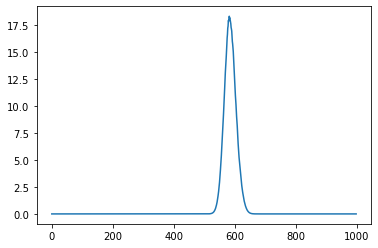

In [13]:
plt.plot(p_m.cpu())

In [14]:
#simps(w_hat_b_np,p_m.cpu().numpy())

In [15]:
p2 = p_m

In [16]:
p1 = p_m

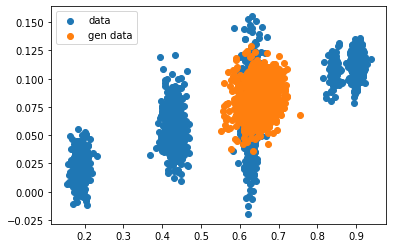

In [17]:
_, _, newV = torch.svd(data)
proj_gen = torch.mm(si, V_g).cpu()/myRBM.Nv**0.5
proj_data = torch.mm(data, V_g).cpu()/myRBM.Nv**0.5
plt.scatter(proj_data[:,0], proj_data[:,1], label = 'data')
plt.scatter(proj_gen[:,0], proj_gen[:,1], label = 'gen data')
plt.legend()

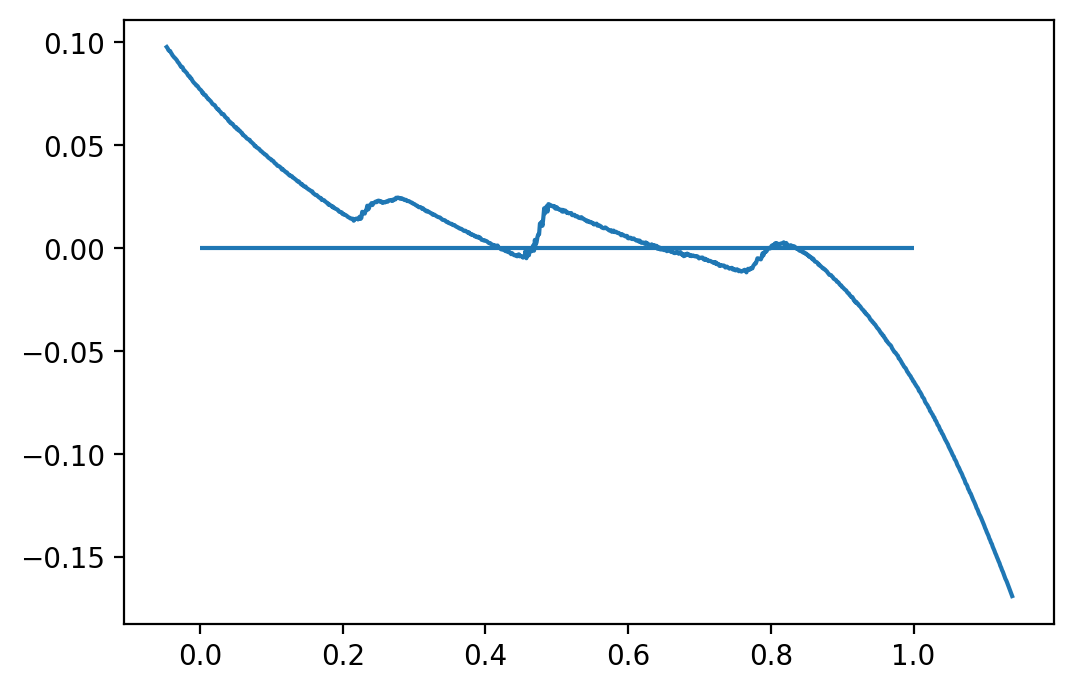

In [18]:
#tmpgrad = np.load("tmpgrad.pt.npy")
plt.figure(dpi = 200)
plt.plot(w_hat_b.cpu().numpy(),newy-w_hat_b.cpu().numpy())
#plt.plot(w_hat_b.cpu().numpy(), x1)
#plt.plot(w_hat_b.cpu().numpy(), tmpgrad)
plt.hlines(0,0,1)

In [19]:
x1 = newy-w_hat_b.cpu().numpy()

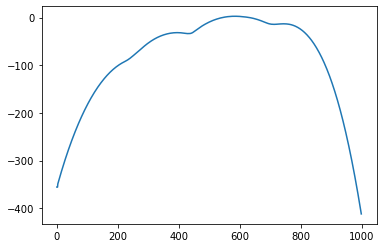

In [20]:

plt.plot(torch.log(p_m).cpu())

In [21]:
i = -1

3852


<ipython-input-22-a690ae2f8b04>:6: RuntimeWarning: divide by zero encountered in log
  ax[0].plot(np.log(p))


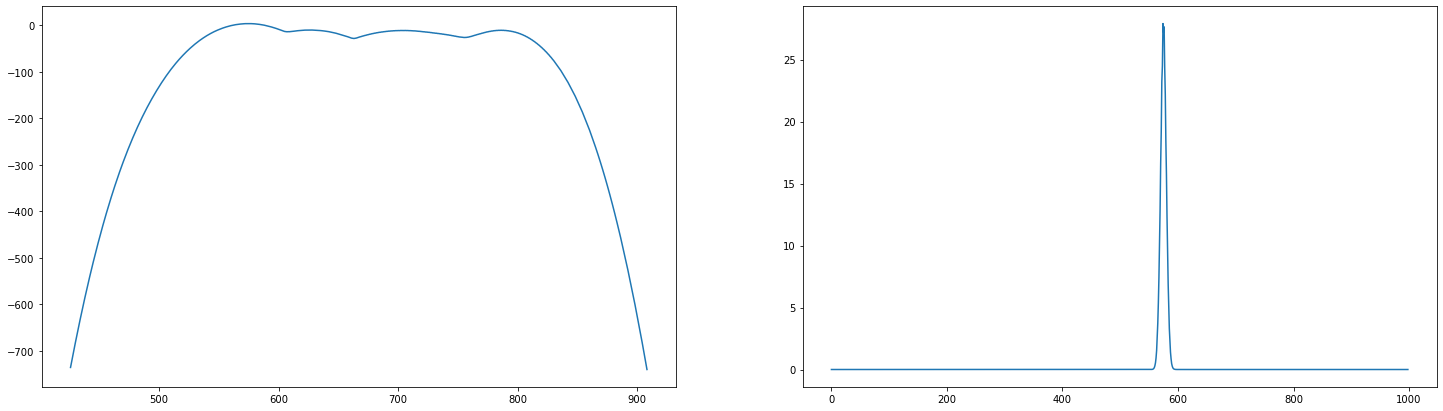

In [22]:
p = f['p_m'+str(alltimes[i])]
print(alltimes[i])
fig, ax = plt.subplots(1,2)
fig.set_figwidth(25)
fig.set_figheight(7)
ax[0].plot(np.log(p))
ax[1].plot(p)
i+=1

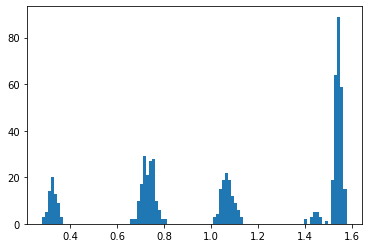

In [23]:
mb = data[:600,:]
a = myRBM.SampleHiddens01(mb)
plt.hist(torch.sum(mb, 1).cpu().numpy()/600, bins = 100);

In [24]:
plt.hist(prod.cpu().numpy().reshape(20000),bins = 100);

ValueError: cannot reshape array of size 40000 into shape (20000,)

In [ ]:
X_pc, _, h_neg_v, h_neg_m = myRBM.GetAv()
neggradW = h_neg_v.mm(X_pc.t())/100
#proj_grad_W = torch.mm(neggradW, V_g)[:,0]
plt.hist(neggradW.cpu().numpy().reshape(20000), bins = 100);

In [ ]:
plt.xlim(0.1,0.2)
plt.plot(w_hat_b.cpu().numpy(),newy-w_hat_b.cpu().numpy())
plt.hlines(0,xmin,xmax)

In [ ]:
 _, S, _ = torch.svd(myRBM.W)
plt.plot(S.cpu())
plt.plot(S_d.cpu()[:len(S)])
plt.semilogy()

In [ ]:
plt.plot(S.cpu())
plt.plot(S_d.cpu())
plt.semilogy()

In [ ]:
S = torch.zeros(10, len(alltimes), device = device)
for i in range(len(alltimes)):
    t = alltimes[i]
    _, tmpS, tmpV = torch.svd(torch.tensor(f['W'+str(t)], device = device))
    if torch.mean(tmpV[:,0])<0:
        tmpV = -tmpV
    plt.plot(tmpV[:,0].cpu(), zorder=0)
    S[:,i] = tmpS[:10]
plt.hlines(1/np.sqrt(1000), 0, 1000, color = 'black', zorder=10)


In [ ]:
plt.plot(alltimes,S.T.cpu())
plt.xlabel("nb_upd");

In [ ]:
nb_chain = 15 # Nb de chaines pour chaque w_hat
it_mcmc = 100 # Nb it_mcmc pour chaque chaine
it_mean = 70 # Nb it considérée pour la moyenne temporelle de chaque chaine
N = 20000 # Contrainte
nb_point = 10000 # Nb de points de discrétisation pour w_hat
xmin = -0.0 
xmax = 1.0

In [ ]:
def TMCSample(v, w_hat, N, V,it_mcmc=100,it_mean=50, ß=1):
    #print("Initialisation")
    #s = time.time()
    vtab = torch.zeros(v.shape, device = device)
    v_curr = v
    V = V
    norm = 1/(v_curr.shape[0]**0.5)
    w_curr = (torch.mv(v_curr.T, V)*norm)
    
    index = torch.randperm(v_curr.shape[0])
    #print(time.time()-s)
    #print("IT MCMC")
    #s = time.time()

    for t in range(it_mcmc):
        #print('init it')
        print(t)
        h_curr, _ = myRBM.SampleHiddens01(v_curr)
        h_i = (torch.mm(myRBM.W.T, h_curr)+myRBM.vbias.reshape(v.shape[0],1)) # Nv x Ns
        w_next = w_curr.clone()
        
        v_next = torch.clone(v_curr)
        index = torch.randperm(v_curr.shape[0])
        for idx in range(v_curr.shape[0]):
            #print('upd comp')
            #s = time.time()
            i = idx
            v_next[i,:] = 1-v_curr[i,:]
            w_next += ((2*v_next[i,:]-1)*V[i]*norm)

            # On calcul -DeltaE
            ΔE = ß*((2*v_next[i,:]-1)*h_i[i,:])-(N/2)*((w_hat-w_next)**2-(w_hat-w_curr)**2)

            tir = torch.rand(v_curr.shape[1],1, device = torch.device("cuda")).squeeze()
            prob = torch.exp(ΔE).squeeze()
            v_curr[i,:] = torch.where(tir<prob, v_next[i,:], v_curr[i,:])
            v_next[i,:] = torch.where(tir<prob, v_next[i,:], 1-v_next[i,:])
            w_curr = torch.where(tir<prob, w_next, w_curr)
            w_next = torch.where(tir<prob, w_next, w_curr)
            #print(time.time()-s)
        if (t>= (it_mcmc-it_mean)):
            vtab += v_curr
    #print(time.time()-s)

    vtab = vtab*(1/it_mean)    
    return v_curr, h_curr, vtab

In [ ]:
start = torch.bernoulli(torch.rand(myRBM.Nv, nb_chain*nb_point, device = device))
V0 = V[:,0]
# w_hat = torch.dot(start.T, V)[0:,]
w_hat_b = torch.linspace(xmin, xmax, steps =nb_point, device = device)
w_hat = torch.zeros(nb_chain*nb_point, device = device)
for i in range(nb_point):
    for j in range(nb_chain):
        w_hat[i*nb_chain+j] = w_hat_b[i]
tmpv, tmph, vtab = TMCSample(start, w_hat, N, V_g[:,0], it_mcmc = it_mcmc, it_mean=it_mean)



In [ ]:
y = np.array(torch.mm(vtab.T, V_g).cpu().squeeze())/myRBM.Nv**0.5
newy = np.array([np.mean(y[i*nb_chain:i*nb_chain+nb_chain]) for i in range(nb_point)])
w_hat = w_hat.cpu().numpy()
w_hat_b = w_hat_b.cpu().numpy()


In [ ]:
res=np.zeros(len(w_hat_b)-1)
for i in range(1,len(w_hat_b)):
    res[i-1] = simps(newy[:i]-w_hat_b[:i], w_hat_b[:i])


In [ ]:
const = simps(np.exp(N*res-np.max(N*res)), w_hat_b[:-1])
p_m = np.exp(N*res-np.max(N*res))/const

In [ ]:
print(simps(p_m, w_hat_b[:-1]))
potential = res + (1/N)*np.log(const)

In [ ]:
print(np.exp((N*res-np.max(N*res))))
print(const)
print(res)

In [ ]:
proj_data =torch.mm(torch.tensor(data, device = device, dtype = dtype), V_g).cpu()/myRBM.Nv**0.5
fig, ax1 = plt.subplots(dpi = 200)

color = 'tab:red'
ax1.set_xlabel("w_hat")
ax1.plot(w_hat_b,newy-w_hat_b,color='red', label = "grad potential")
ax1.plot(w_hat_b[1:], potential, label = 'potential')
ax1.hlines(0,0,1, color = 'black')
#ax1.scatter(proj_gen[:,0], proj_gen[:,1],alpha=0.2, label = 'data_gen')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
rdm_y = torch.randn(proj_data[:,0].shape)/20
ax2.hist(proj_data[:,0].numpy(), label = 'data', density=True, bins=200)
ax2.plot(w_hat_b[1:], p_m, color = "green", label = "prob")

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend()
ax2.legend()
plt.show()

In [ ]:
plt.plot( w_hat_b, w_hat_b-newy)

In [ ]:
plt.plot(w_hat_b[1:], p_m, color = "green", label = "prob")


In [ ]:
p_m

In [ ]:
proj_gen